In [39]:
import sys
sys.path.insert(0, './utils/')
from pluscode import *
from sett import sett

import glob
import time

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from moviepy.editor import VideoFileClip

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

seed = 0

# Load images and visualize:

In [43]:
cars = glob.glob('E:/asu/summer 22/vision/Car_detection_HOG-master/dataset/vehicles/**/*.png')
num_car_image = len(cars)

notcars = glob.glob('E:/asu/summer 22/vision/Car_detection_HOG-master/dataset/non-vehicles/**/*.png')
num_not_car_image = len(notcars)

print('# car images:', num_car_image, '\n# non-car images:', num_not_car_image)

# car images: 575 
# non-car images: 9068


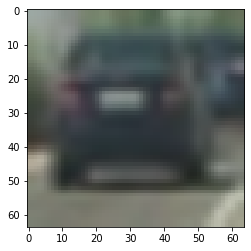

In [41]:
image_test1 = np.asarray(Image.open(cars[0]))
plt.imshow(image_test1)

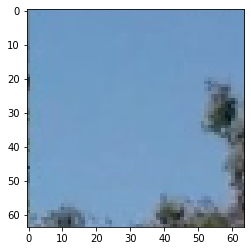

In [5]:
image_test2 = np.asarray(Image.open(notcars[0]))
plt.imshow(image_test2)

In [6]:
for i in range(len(cars)):
    cars[i] = np.asarray(Image.open(cars[i]))

for i in range(len(notcars)):
    notcars[i] = np.asarray(Image.open(notcars[i]))

# Train linear SVM classifier:

In [7]:
car_features = extract_features(cars, 
                                Config.color_space, Config.spatial_size, 
                                Config.hist_bins, Config.orient,
                                Config.pix_per_cell, Config.cell_per_block,
                                Config.hog_channel, Config.spatial_feat,
                                Config.hist_feat, Config.hog_feat)

notcar_features = extract_features(notcars,
                                   Config.color_space, Config.spatial_size,
                                   Config.hist_bins, Config.orient,
                                   Config.pix_per_cell, Config.cell_per_block,
                                   Config.hog_channel, Config.spatial_feat,
                                   Config.hist_feat, Config.hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

X_scaler = StandardScaler().fit(X_train)

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

if Config.hist_feat:
    print('Using:', Config.hist_bins, 'bins for color histogram feature.')

if Config.hog_feat:
    print('Using:', Config.orient, 'orientations,', Config.pix_per_cell,
        'pixels per cell, and', Config.cell_per_block, 'cells per block for HOG feature.')
    
print('Feature vector length:', len(X_train[0]))

Using: 16 bins for color histogram feature.
Using: 9 orientations, 8 pixels per cell, and 2 cells per block for HOG feature.
Feature vector length: 6108


In [8]:
# Use a linear SVC 
parameters = {
    'C': np.logspace(-5, 5, 10)
}

gs_svc = GridSearchCV(LinearSVC(), parameters, cv=3)

t=time.time()
gs_svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

svc = gs_svc.best_estimator_
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

135.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


# Test on one image

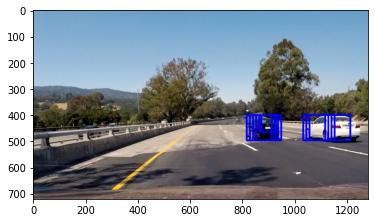

In [36]:
img = np.asarray(Image.open('E:/asu/summer 22/2/car/dataset/test_images/test1.jpg'))

out_img, box_list = find_cars(img, svc, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)

plt.imshow(out_img)

# Main Pipeline

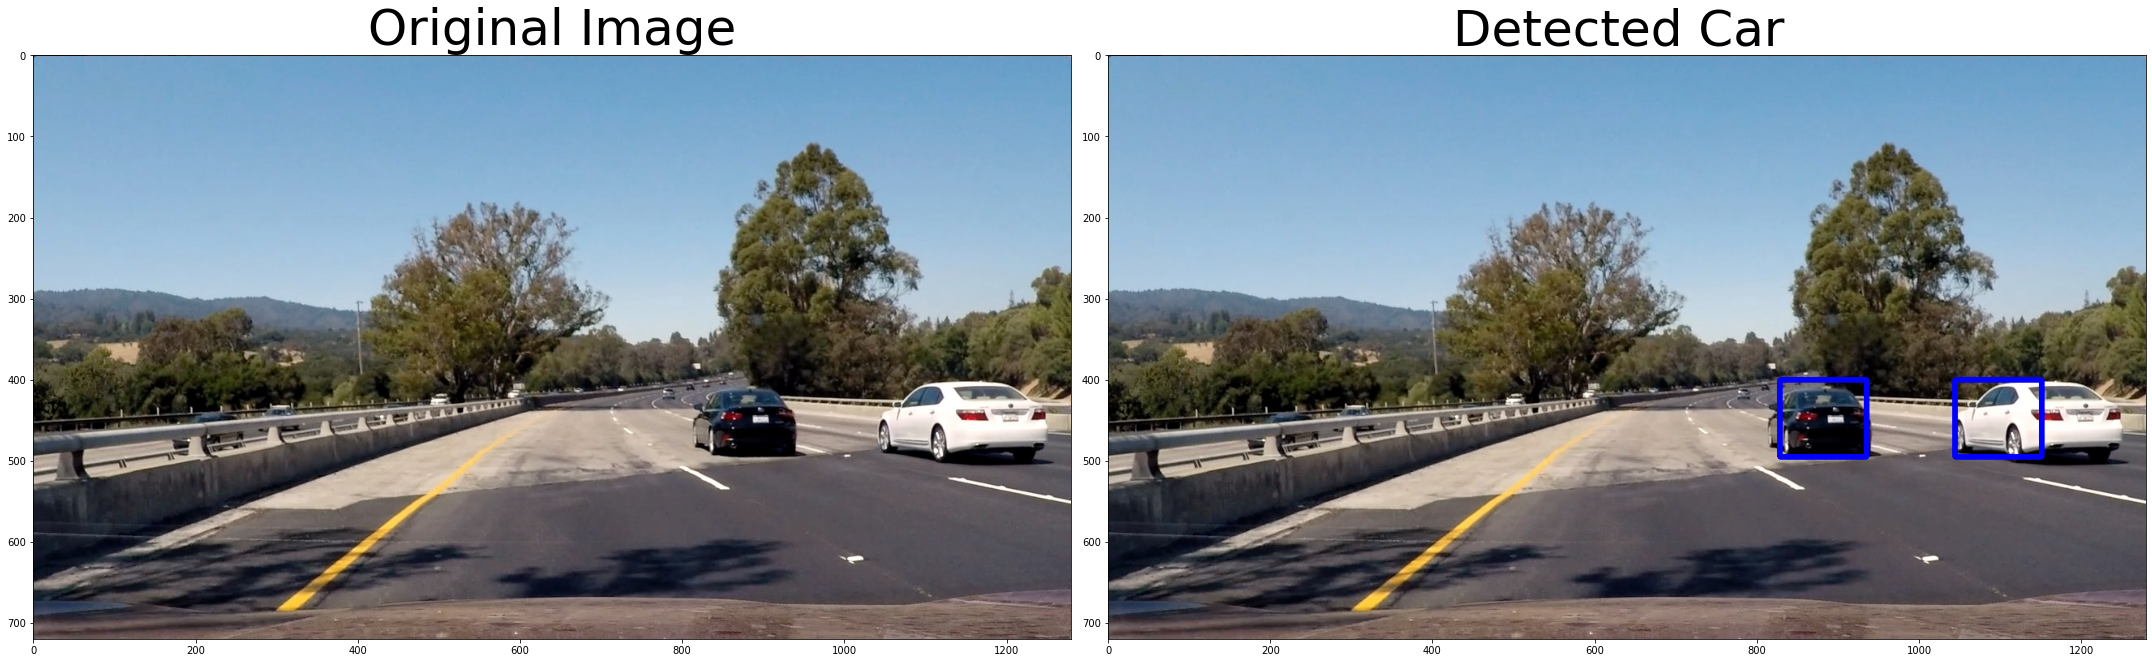

In [37]:
def main_pipeline(img):
    out_img, box_list = find_cars(img, svc, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, box_list)
    heatmap = apply_threshold(heatmap, 2)


    labels = label(heatmap, return_num=True)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

image = np.asarray(Image.open('E:/asu/summer 22/2/car/dataset/test_images/test1.jpg'))
draw_img = main_pipeline(img)

fig = plt.figure(figsize=(30,20))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image', {'fontsize': 50})
plt.subplot(122)
plt.imshow(draw_img)
plt.title('Detected Car ', {'fontsize': 50})
fig.tight_layout()

# Test on video

In [22]:
white_output = 'project_video_outputtt345.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(main_pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_video_outputtt345.mp4.
Moviepy - Writing video project_video_outputtt345.mp4



Moviepy - Done !
Moviepy - video ready project_video_outputtt345.mp4
CPU times: total: 1h 17min 24s
Wall time: 1h 18min 58s
